In [3]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
import datetime
import tables 
import tstables  
import os
from indicators import *
from sklearn import svm
import talib as ta

from sklearn import mixture as mix
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def write2excel( df, filename ):
    filepath = os.path.join('..', '..', 'datastore', filename) + '.xlsx'
    writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
    df.to_excel(writer )
    writer.save()
    

In [5]:
symbol = 'AUD_USD'
account_type = 'practice'
granularity = 'S5'
start_datetime = datetime.datetime(2010,1,1,0,0,0)
end_datetime = datetime.datetime(2018,1,1,0,0,0)
decision_frequency = '4H'

file_path = '..\\..\\datastore\\_{0}\\{1}\\{2}.h5'.format(account_type,symbol,granularity)

h5 = tables.open_file(file_path, 'r')
ts = h5.root.data._f_get_timeseries()
raw = ts.read_range(start_datetime,end_datetime)
raw = pd.DataFrame(raw)
                
# Aggregate the high frequency data to the decision frequency
ohlc_dict = {   'ask_o':'first', 'ask_h':'max', 'ask_l':'min', 'ask_c': 'last',                                                                                                    
                'bid_o':'first', 'bid_h':'max', 'bid_l':'min', 'bid_c': 'last',                                                                                                    
                'volume': 'sum' }

df = raw.resample(decision_frequency, closed='left', label='left').apply(ohlc_dict).dropna()

df = df.rename(columns={'index': 'date', 'bid_o': 'Open', 'bid_h': 'High', 'bid_l': 'Low', 'bid_c': 'Close', })
df=df[['Open','High','Low','Close']]


In [6]:
df.head()

,Open,High,Low,Close
2010-01-03 16:00:00,0.89720,0.89824,0.89630,0.89808
2010-01-03 20:00:00,0.89813,0.89966,0.89675,0.89716
2010-01-04 00:00:00,0.89719,0.89827,0.89380,0.89639
2010-01-04 04:00:00,0.89643,0.90075,0.89620,0.90047
2010-01-04 08:00:00,0.90051,0.90669,0.90038,0.90562


In [7]:
n = 10
t = 0.8
split =int(t*len(df))

df['high']=df['High'].shift(1)
df['low']=df['Low'].shift(1)
df['close']=df['Close'].shift(1)
df['RSI']=ta.RSI(np.array(df['close']), timeperiod=n)
df['SMA']= df['close'].rolling(window=n).mean()
df['Corr']= df['SMA'].rolling(window=n).corr(df['close'])
df['SAR']=ta.SAR(np.array(df['high']),np.array(df['low']),0.2,0.2)
df['ADX']=ta.ADX(np.array(df['high']),np.array(df['low']),np.array(df['close']), timeperiod =n)
df['Corr'][df.Corr>1]=1
df['Corr'][df.Corr<-1]=-1 
df['Return']= np.log(df['Open']/df['Open'].shift(1))

df=df.dropna()

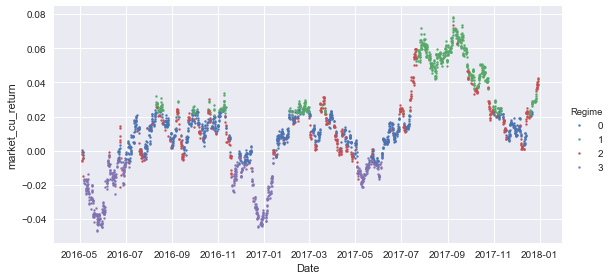

In [11]:
ss= StandardScaler()
unsup = mix.GaussianMixture(n_components=4, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=42)
df=df.drop(['High','Low','Close'],axis=1)
unsup.fit(np.reshape(ss.fit_transform(df[:split]),(-1,df.shape[1])))
regime = unsup.predict(np.reshape(ss.fit_transform(df[split:]),\
                                                   (-1,df.shape[1])))

Regimes=pd.DataFrame(regime,columns=['Regime'],index=df[split:].index)\
                     .join(df[split:], how='inner')\
                          .assign(market_cu_return=df[split:]\
                                  .Return.cumsum())\
                                  .reset_index(drop=False)\
                                  .rename(columns={'index':'Date'})

order=[0,1,2,3]
fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,size= 4)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend()
plt.show()


In [12]:
for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variance for regime %i: '%i,(unsup.covariances_[i]))

print(Regimes.head())

ss1 =StandardScaler()
columns =Regimes.columns.drop(['Regime','Date'])    
Regimes[columns]= ss1.fit_transform(Regimes[columns])
Regimes['Signal']=0
Regimes.loc[Regimes['Return']>0,'Signal']=1
Regimes.loc[Regimes['Return']<0,'Signal']=-1
Regimes['return'] = Regimes['Return'].shift(1)
Regimes=Regimes.dropna()
       
cls= SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

split2= int(.8*len(Regimes))

X = Regimes.drop(['Signal','Return','market_cu_return','Date'], axis=1)
y= Regimes['Signal']

cls.fit(X[:split2],y[:split2])

Mean for regime 0:  -0.147640606177
Co-Variance for regime 0:  0.288722855579
Mean for regime 1:  0.937407485666
Co-Variance for regime 1:  0.360206745312
Mean for regime 2:  0.209897804608
Co-Variance for regime 2:  0.706759110384
Mean for regime 3:  -1.58264251224
Co-Variance for regime 3:  0.48578438033
                 Date  Regime     Open     high      low    close        RSI  \
0 2016-05-04 04:00:00       2  0.74898  0.75094  0.74663  0.74894  28.300491   
1 2016-05-04 08:00:00       0  0.74996  0.75168  0.74891  0.74992  31.389573   
2 2016-05-04 12:00:00       2  0.74822  0.74996  0.74599  0.74824  29.008974   
3 2016-05-04 16:00:00       2  0.74518  0.74961  0.74495  0.74514  25.105279   
4 2016-05-04 20:00:00       2  0.74555  0.74657  0.74461  0.74549  26.348614   

        SMA      Corr       SAR        ADX    Return  market_cu_return  
0  0.758089  0.700841  0.760387  30.500813 -0.000921         -0.000921  
1  0.756681  0.692559  0.757636  31.890515  0.001308          0.0

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

2017-08-31 00:00:00   -1
2017-08-31 04:00:00   -1
2017-08-31 08:00:00   -1
2017-08-31 12:00:00   -1
2017-08-31 16:00:00    1
2017-08-31 20:00:00   -1
2017-09-01 00:00:00    1
2017-09-01 04:00:00    1
2017-09-01 08:00:00   -1
2017-09-01 12:00:00    1
2017-09-01 16:00:00    1
2017-09-01 20:00:00   -1
2017-09-03 20:00:00    1
2017-09-04 00:00:00    1
2017-09-04 04:00:00    1
2017-09-04 08:00:00    1
2017-09-04 12:00:00    1
2017-09-04 16:00:00    1
2017-09-04 20:00:00    1
2017-09-05 00:00:00   -1
2017-09-05 04:00:00    1
2017-09-05 08:00:00    1
2017-09-05 12:00:00    1
2017-09-05 16:00:00    1
2017-09-05 20:00:00    1
2017-09-06 00:00:00    1
2017-09-06 04:00:00   -1
2017-09-06 08:00:00    1
2017-09-06 12:00:00   -1
2017-09-06 16:00:00    1
                      ..
2017-12-22 04:00:00    1
2017-12-22 08:00:00    1
2017-12-22 12:00:00    1
2017-12-22 16:00:00    1
2017-12-22 20:00:00    1
2017-12-25 20:00:00    1
2017-12-26 00:00:00    1
2017-12-26 04:00:00    1
2017-12-26 08:00:00    1


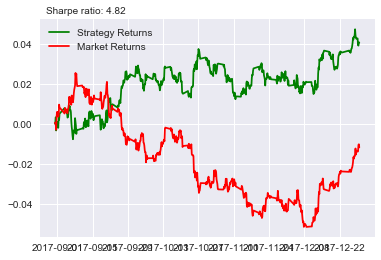

In [13]:
p_data=len(X)-split2

df['Pred_Signal']=0
df.iloc[-p_data:,df.columns.get_loc('Pred_Signal')]=cls.predict(X[split2:])

print(df['Pred_Signal'][-p_data:])

df['str_ret'] =df['Pred_Signal']*df['Return'].shift(-1)

df['strategy_cu_return']=0.
df['market_cu_return']=0.
df.iloc[-p_data:,df.columns.get_loc('strategy_cu_return')] \
       = np.nancumsum(df['str_ret'][-p_data:])
df.iloc[-p_data:,df.columns.get_loc('market_cu_return')] \
       = np.nancumsum(df['Return'][-p_data:])
Sharpe = (df['strategy_cu_return'][-1]-df['market_cu_return'][-1])\
           /np.nanstd(df['strategy_cu_return'][-p_data:])

plt.plot(df['strategy_cu_return'][-p_data:],color='g',label='Strategy Returns')
plt.plot(df['market_cu_return'][-p_data:],color='r',label='Market Returns')
plt.figtext(0.14,0.9,s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()



'1.13.3'